In [1]:
import os

os.chdir("..\\..\\..\\")  # Ensure Current working directory is top level folder where venv is.

import os.path
import re

import numpy as np
import matplotlib.pyplot as plt

from source.models.noise.noise_sweep import NoiseSweep
from source.services.fits_data_unpack_service import FitsDataUnpackService
from source.services.fits_file_load_service import FitsFileLoadService
from source.services.hidfmux_pkl_file_load_service import HidfmuxFileLoadService
from source.util import noise_multiplication_method_tools
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:

multi_tone_directory=r"C:\Users\c2047423\OneDrive - Cardiff University\Documents\Gethin - PhD\Device Data\SPT-SLIM\slim_v2_anlw001_idc_stepdown\Ice_board_data\140mK_0p005_amp"
dut="slim_v2_anlw001_idc_stepdown"
single_tone_directory=r"C:\Users\c2047423\OneDrive - Cardiff University\Documents\Gethin - PhD\Device Data\SPT-SLIM\slim_v2_anlw001_idc_stepdown\Data\20230831_Dark_Data_Prelim\KID_K171\Set_Temperature_140_mK\Set_Attenuation_50dB"
tone_to_plot="K171"
temperature=0.14
save_figures=False


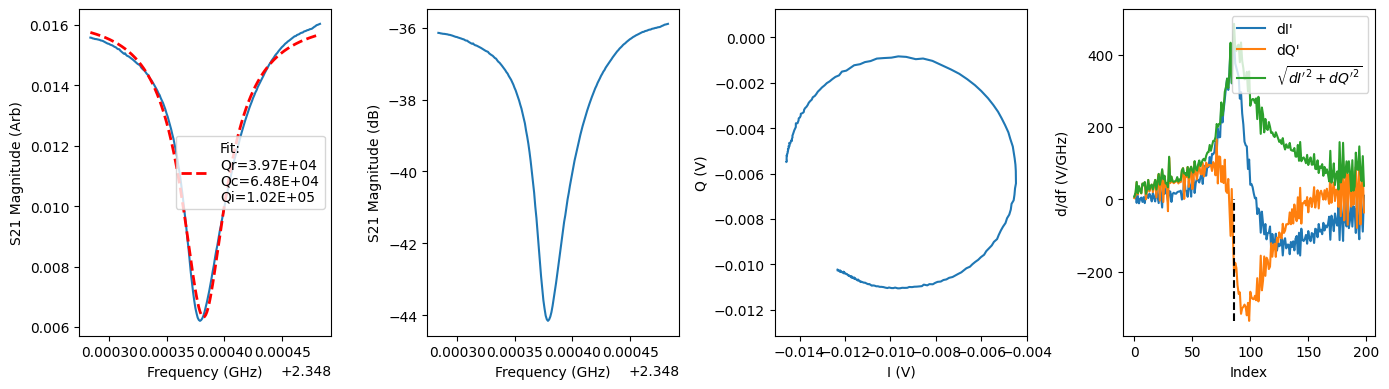

In [3]:


multi_tone_timestream_file_name = "noise_timestream_" + tone_to_plot + ".pkl"
multisweep_file_name = "res_detail_multi_sweep.pkl"

#*******************************************************************************************************************

# Multi tone:

multi_sweep_path = os.path.join(multi_tone_directory, multisweep_file_name)
timestream_path = os.path.join(multi_tone_directory, multi_tone_timestream_file_name)

# Get sweep data for KID:
multisweep = HidfmuxFileLoadService.load_pkl_multi_sweep_file(multi_sweep_path)
multi_tone_sweep_data = multisweep.get_tone_sweep_data(tone=tone_to_plot)
multi_tone_noise_sweep = NoiseSweep(
    dut=dut,
    tone_name=tone_to_plot,
    temperature=temperature,
    input_attenuation=multisweep.get_tone_bias_power(tone=tone_to_plot),
    sweep_data=multi_tone_sweep_data
)
multi_tone_noise_sweep.plot_sweep(save_figure=save_figures, save_to_directory="..\\..\\..\\Figures")

#...................................................................................................................

# Load timestream data:

on_res_timestream, off_res_timestream = HidfmuxFileLoadService.load_pkl_timestream_file(
    timestream_file_path=timestream_path,
    multisweep=multisweep,
    tone_name=tone_to_plot
)


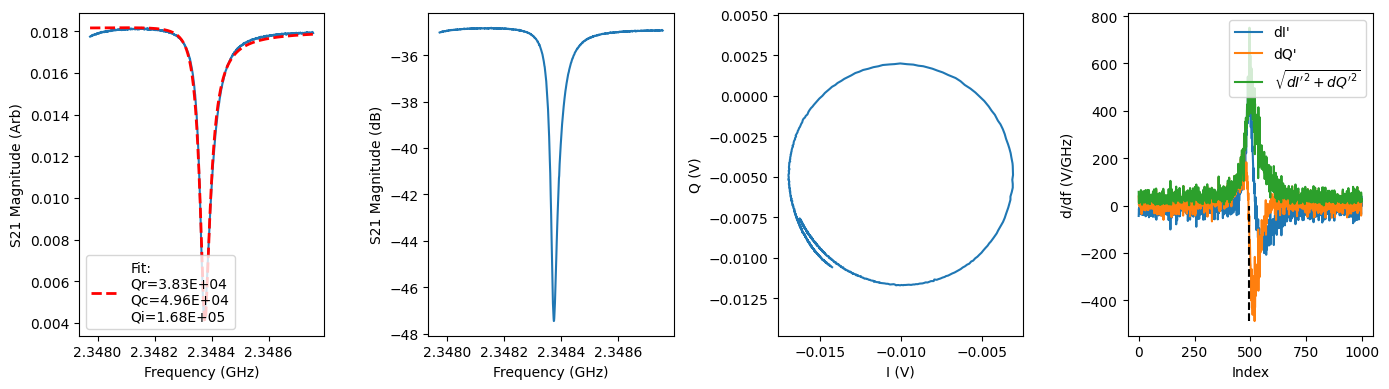

c:\Python_Projects\Analysis\general_device_analysis\venv\lib\site-packages\scipy\signal\_spectral_py.py:1852: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


In [4]:
# Single Tone Noise Packet

single_tone_noise_packet_psd = noise_multiplication_method_tools.get_single_tone_noise_packet_psd(
    directory=single_tone_directory,
    down_sample_psd=True,
    down_sample_bins=100,
    plot_sweep_figure=True,
    save_figures=save_figures,
    save_to_directory="..\\..\\..\\Figures",
)

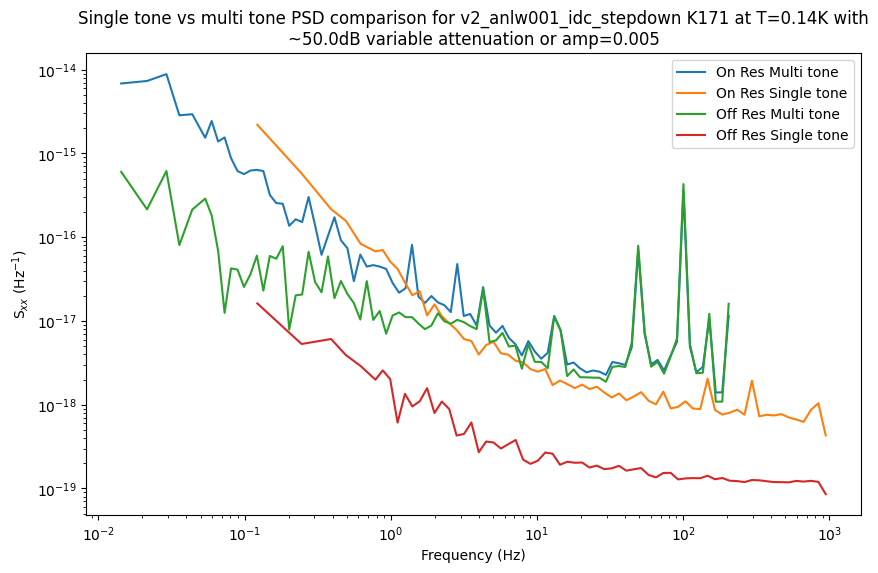

In [6]:
from source.util import noise_multiplication_method_tools
from source.util import resonator_noise_analysis_tools

multi_tone_noise_packet_psd = noise_multiplication_method_tools.get_simple_noise_packet_psd(
    noise_sweep=multi_tone_noise_sweep,
    on_res_timestream=on_res_timestream,
    off_res_timestream=off_res_timestream,
    down_sample_psd=True,
    down_sample_bins=100
)

multi_tone_noise_packet_psd.correct_psd_for_cic_filter(trim_percentage=0.0001)

# ******************************************************************************************************************

plt.figure(figsize=(10, 6))
plt.plot(
    multi_tone_noise_packet_psd.on_res_frequencies,
    multi_tone_noise_packet_psd.on_res_psd,
    label="On Res Multi tone",
)
plt.plot(
    single_tone_noise_packet_psd.on_res_low_frequencies,
    single_tone_noise_packet_psd.psd_on_res_low,
    label="On Res Single tone",
)
plt.plot(
    multi_tone_noise_packet_psd.off_res_frequencies,
    multi_tone_noise_packet_psd.off_res_psd,
    label="Off Res Multi tone",
)
plt.plot(
    single_tone_noise_packet_psd.off_res_low_frequencies,
    single_tone_noise_packet_psd.psd_off_res_low,
    label="Off Res Single tone",
)
plt.xlabel("Frequency (Hz)")
plt.ylabel("S$_{xx}$ (Hz$^{-1}$)")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.title(
    f"Single tone vs multi tone PSD comparison for {single_tone_noise_packet_psd.dut} "
    f"{single_tone_noise_packet_psd.tone_name} at T={single_tone_noise_packet_psd.temperature}K with"
    f"\n~{single_tone_noise_packet_psd.input_attenuation}dB variable attenuation or "
    f"amp={multi_tone_noise_packet_psd.input_attenuation}"
)
plt.show()